In [98]:
# Import libraries

import numpy as np
import sympy as sp
from scipy.optimize import minimize_scalar
import matplotlib.pyplot as plt

In [99]:
# Symbolic differentiation and NumPy conversion

# Symbolic definition
x = sp.symbols('x')
f_expr = (x-1)**3

# Derivatives
fp_expr  = sp.diff(f_expr, x)
fpp_expr     = sp.diff(f_expr, x, 2)

# Convert to NumPy-callable functions
f     = sp.lambdify(x, f_expr, "numpy")
fprime = sp.lambdify(x, fp_expr, "numpy")
fpp    = sp.lambdify(x, fpp_expr, "numpy")

print("f(x) =", f_expr)
print("f'(x) =", fp_expr)
print("f''(x) =", fpp_expr)

f(x) = (x - 1)**3
f'(x) = 3*(x - 1)**2
f''(x) = 6*(x - 1)


In [100]:
# aBB underestimator

# Analytic form of underestimator
a_sym, b_sym, alpha_sym = sp.symbols('a b alpha', real=True)
g_expr = f_expr + alpha_sym*(x - a_sym)*(x - b_sym)

print("g(x; a,b,alpha) =", g_expr)

# Function to be used later to evaluate underestimator values
def g(x, a, b, alpha):
    return f(x) + alpha * (x-a)*(x-b)

g(x; a,b,alpha) = alpha*(-a + x)*(-b + x) + (x - 1)**3


In [101]:
# Check the convexity of underestimator

def is_convex(a, b, alpha, n_points=200):
    xs = np.linspace(a, b, n_points)
    vals = fpp(xs) + 2*alpha   # f''(x) + 2*alpha
    return np.all(vals >= 0)

# Example
print("Convex?", is_convex(-2, 2, alpha=10))

Convex? True


In [102]:
# Bound estimation

def bounds(a, b, alpha):
    res_lb = minimize_scalar(lambda xx: g(xx, a, b, alpha), bounds=(a,b), method="bounded")
    LB = res_lb.fun

    res_ub = minimize_scalar(f, bounds=(a,b), method="bounded")
    UB = res_ub.fun

    return LB, UB

# Example
LB, UB = bounds(-2, 2, alpha=10)
print(f"LB={LB:.4f}, UB={UB:.4f}")

LB=-41.3320, UB=-26.9998


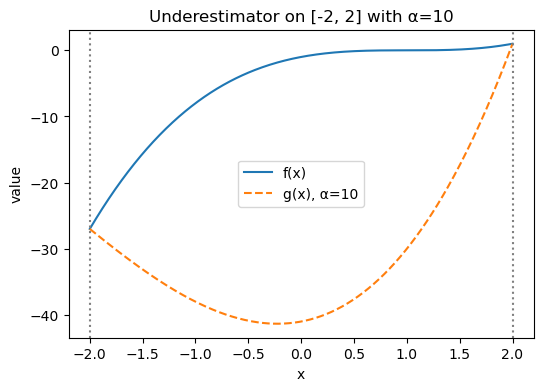

In [103]:
# Generate plot

def plot_underestimator(a, b, alpha):
    xs = np.linspace(a, b, 400)
    ys_f = f(xs)
    ys_g = g(xs, a, b, alpha)

    plt.figure(figsize=(6,4))
    plt.plot(xs, ys_f, label="f(x)")
    plt.plot(xs, ys_g, "--", label=f"g(x), α={alpha}")
    plt.axvline(a, color="gray", linestyle=":")
    plt.axvline(b, color="gray", linestyle=":")
    plt.legend()
    plt.xlabel("x")
    plt.ylabel("value")
    plt.title(f"Underestimator on [{a}, {b}] with α={alpha}")
    plt.show()

# Example
plot_underestimator(-2, 2, 10)

f(x) = (x + y**2 - 7)**2 + (x**2 + y - 11)**2
f'(x) = 4*(x + y)
f''(x) = 4
g(x, y; a1, b1, a2, b2, alpha) = alpha*((-a1 + x)*(-b1 + x) + (-a2 + y)*(-b2 + y)) + (x + y**2 - 7)**2 + (x**2 + y - 11)**2
Convex? True
LB=-7032.0060, UB=0.0000


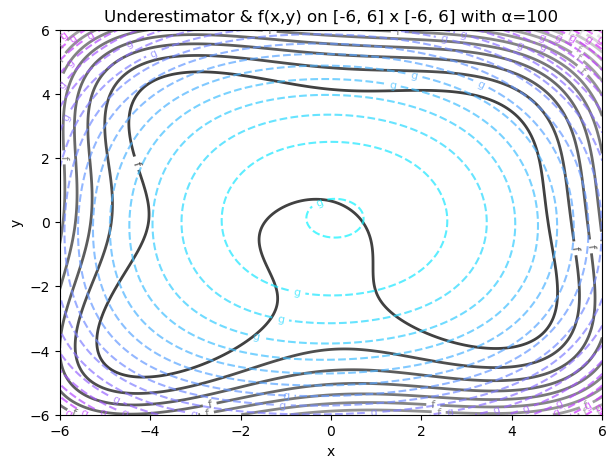

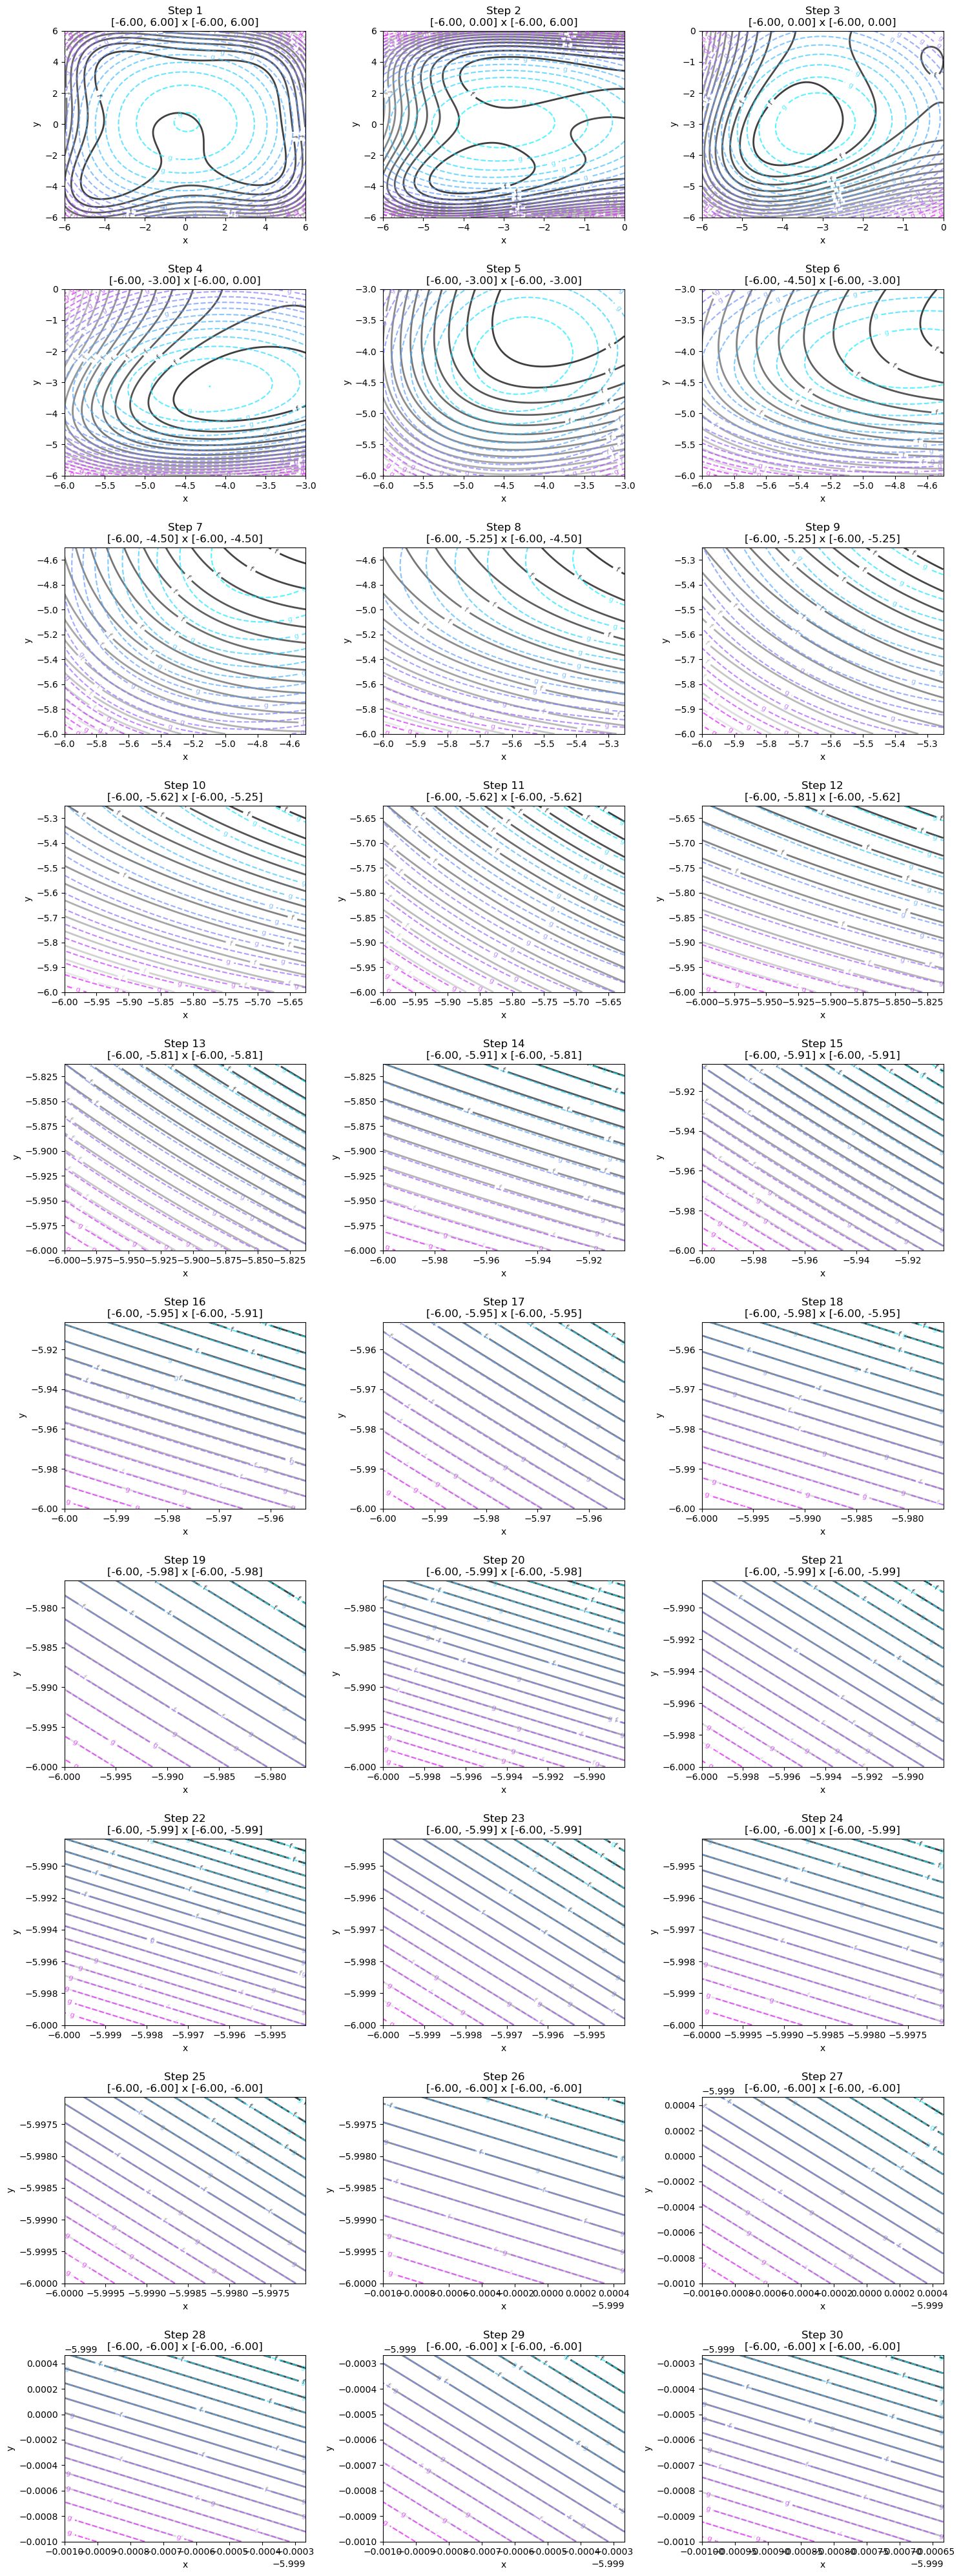

최종 최적점 (추정): x = -5.999817, y = -5.999634


In [104]:
# Symbolic differentiation and NumPy conversion
from scipy.optimize import minimize

# Symbolic definition
x, y = sp.symbols('x y')
f_expr = (x**2 + y - 11)**2 + (x + y**2 - 7)**2

# Derivatives
fp_expr  = sp.diff(f_expr, x, y)
fpp_expr     = sp.diff(f_expr, x, y, 2)

# Convert to NumPy-callable functions
f     = sp.lambdify((x, y), f_expr, "numpy")
fprime = sp.lambdify((x, y), fp_expr, "numpy")
fpp    = sp.lambdify((x, y), fpp_expr, "numpy")

print("f(x) =", f_expr)
print("f'(x) =", fp_expr)
print("f''(x) =", fpp_expr)

# aBB 언더에스티메이터 (f_expr에 맞게 수정)

# 분석적 언더에스티메이터 정의 (2변수)
a1_sym, b1_sym, a2_sym, b2_sym, alpha_sym = sp.symbols('a1 b1 a2 b2 alpha', real=True)
g_expr = f_expr + alpha_sym * ((x - a1_sym)*(x - b1_sym) + (y - a2_sym)*(y - b2_sym))

print("g(x, y; a1, b1, a2, b2, alpha) =", g_expr)

# 언더에스티메이터 함수 (2변수)
def g(x, y, a1, b1, a2, b2, alpha):
    return f(x, y) + alpha * ((x - a1)*(x - b1) + (y - a2)*(y - b2))

# 언더에스티메이터의 볼록성 확인 (2변수)
def is_convex(a1, b1, a2, b2, alpha, n_points=50):
    xs = np.linspace(a1, b1, n_points)
    ys = np.linspace(a2, b2, n_points)
    X, Y = np.meshgrid(xs, ys)
    # 각 (x, y)에서 Hessian 행렬을 계산하고, 모든 고유값이 0보다 큰지 확인
    for i in range(n_points):
        for j in range(n_points):
            x0 = X[i, j]
            y0 = Y[i, j]
            # f_expr의 Hessian 계산 (심볼릭)
            H = sp.hessian(f_expr, (x, y))
            # alpha 항을 더한 Hessian
            H_num = np.array(H.subs({x: x0, y: y0})).astype(np.float64)
            H_num[0,0] += 2*alpha
            H_num[1,1] += 2*alpha
            eigvals = np.linalg.eigvals(H_num)
            if np.any(eigvals <= 0):
                return False
    return True

# 예시
print("Convex?", is_convex(-6, 6, -6, 6, alpha=100))

# 바운드 추정 (2변수)
def bounds(a1, b1, a2, b2, alpha):
    # g(x, y)의 최소값 (언더에스티메이터)
    res_lb = minimize(lambda xy: g(xy[0], xy[1], a1, b1, a2, b2, alpha),
                      x0=[(a1+b1)/2, (a2+b2)/2],
                      bounds=[(a1, b1), (a2, b2)])
    LB = res_lb.fun

    # f(x, y)의 최소값 (진짜 upper bound)
    res_ub = minimize(lambda xy: f(xy[0], xy[1]),
                      x0=[(a1+b1)/2, (a2+b2)/2],
                      bounds=[(a1, b1), (a2, b2)])
    UB = res_ub.fun

    return LB, UB

# 예시
LB, UB = bounds(-6, 6, -6, 6, alpha=100)
print(f"LB={LB:.4f}, UB={UB:.4f}")

# 언더에스티메이터 시각화 (x-y 평면에서 contour plot)
def plot_underestimator(a1, b1, a2, b2, alpha):
    xs = np.linspace(a1, b1, 200)
    ys = np.linspace(a2, b2, 200)
    X, Y = np.meshgrid(xs, ys)
    Zf = f(X, Y)
    Zg = g(X, Y, a1, b1, a2, b2, alpha)

    plt.figure(figsize=(7,5))
    # 실제 함수의 값 contour (굵은 실선)
    cs0 = plt.contour(X, Y, Zf, levels=20, cmap='gray', linewidths=2, alpha=0.8)
    # 언더에스티메이터 contour (점선)
    cs1 = plt.contour(X, Y, Zg, levels=20, cmap='cool', linestyles='--', alpha=0.7)
    plt.clabel(cs0, inline=True, fontsize=8, fmt="f")
    plt.clabel(cs1, inline=True, fontsize=8, fmt="g")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title(f"Underestimator & f(x,y) on [{a1}, {b1}] x [{a2}, {b2}] with α={alpha}")
    plt.show()

# 예시
plot_underestimator(-6, 6, -6, 6, 100)

# alpha-BB를 통한 최적화 과정을 4단계로 시각화

def plot_alphaBB_steps(a1, b1, a2, b2, alpha, steps=4):
    # 초기 바운드
    bounds_list = []
    bounds_list.append((a1, b1, a2, b2))
    for i in range(steps-1):
        # 현재 바운드에서 중앙점 계산
        c1 = (bounds_list[-1][0] + bounds_list[-1][1]) / 2
        c2 = (bounds_list[-1][2] + bounds_list[-1][3]) / 2
        # x, y축 중 더 긴 구간을 반으로 나눔
        if (bounds_list[-1][1] - bounds_list[-1][0]) >= (bounds_list[-1][3] - bounds_list[-1][2]):
            # x축 분할
            bounds_list.append((bounds_list[-1][0], c1, bounds_list[-1][2], bounds_list[-1][3]))
        else:
            # y축 분할
            bounds_list.append((bounds_list[-1][0], bounds_list[-1][1], bounds_list[-1][2], c2))

    # 3행으로 나누어서 subplot 생성
    ncols = 3
    nrows = (steps + ncols - 1) // ncols  # steps를 3으로 나눈 후 올림
    fig, axes = plt.subplots(nrows, ncols, figsize=(5*ncols, 4*nrows))
    axes = np.array(axes).reshape(-1)  # 1차원 배열로 변환

    for i, (a1_, b1_, a2_, b2_) in enumerate(bounds_list):
        xs = np.linspace(a1_, b1_, 200)
        ys = np.linspace(a2_, b2_, 200)
        X, Y = np.meshgrid(xs, ys)
        Zf = f(X, Y)
        Zg = g(X, Y, a1_, b1_, a2_, b2_, alpha)
        ax = axes[i]
        # 실제 함수의 값 contour (굵은 실선)
        cs0 = ax.contour(X, Y, Zf, levels=20, cmap='gray', linewidths=2, alpha=0.8)
        # 언더에스티메이터 contour (점선)
        cs1 = ax.contour(X, Y, Zg, levels=20, cmap='cool', linestyles='--', alpha=0.7)
        ax.set_title(f"Step {i+1}\n[{a1_:.2f}, {b1_:.2f}] x [{a2_:.2f}, {b2_:.2f}]")
        ax.set_xlabel("x")
        ax.set_ylabel("y")
        ax.clabel(cs0, inline=True, fontsize=8, fmt="f")
        ax.clabel(cs1, inline=True, fontsize=8, fmt="g")
    # 남는 subplot은 숨김 처리
    for j in range(i+1, nrows*ncols):
        axes[j].axis('off')
    plt.tight_layout()
    plt.show()

# alpha-BB 4단계 시각화 예시
plot_alphaBB_steps(-6, 6, -6, 6, alpha=100, steps=30)
# 최종 최적점(마지막 바운드의 중심)을 계산하여 출력
def print_final_optimal_point(a1, b1, a2, b2, alpha, steps=4):
    # 바운드 리스트 생성 (plot_alphaBB_steps와 동일하게)
    bounds_list = []
    bounds_list.append((a1, b1, a2, b2))
    for i in range(steps-1):
        c1 = (bounds_list[-1][0] + bounds_list[-1][1]) / 2
        c2 = (bounds_list[-1][2] + bounds_list[-1][3]) / 2
        if (bounds_list[-1][1] - bounds_list[-1][0]) >= (bounds_list[-1][3] - bounds_list[-1][2]):
            bounds_list.append((bounds_list[-1][0], c1, bounds_list[-1][2], bounds_list[-1][3]))
        else:
            bounds_list.append((bounds_list[-1][0], bounds_list[-1][1], bounds_list[-1][2], c2))
    # 마지막 바운드의 중심 계산
    last = bounds_list[-1]
    x_opt = (last[0] + last[1]) / 2
    y_opt = (last[2] + last[3]) / 2
    print(f"최종 최적점 (추정): x = {x_opt:.6f}, y = {y_opt:.6f}")

# 예시: steps=30으로 위와 동일하게 출력
print_final_optimal_point(-6, 6, -6, 6, alpha=100, steps=30)
